In [59]:
import tdt
import numpy as np
import matplotlib.pyplot as plt

import scipy.signal as sig

%run fx4assembly.py
%run fx4behavior.py
%run fx4makingsnips.py

%matplotlib inline

In [60]:
test_sessions = metafile2sessions("..\\data\\test_ppp3.xlsx",
                                  "..\\data\\test",
                                  "..\\data\\",
                                  "..\\output\\")

In [61]:
ppp4_sessions = metafile2sessions('D:\\DA_and_Reward\\gc214\\PPP4\\PPP4.xlsx',
                                  'D:\\DA_and_Reward\\gc214\\PPP4\\PPP4_metafile',
                                  'D:\\DA_and_Reward\\gc214\\PPP4\\tdtfiles\\',
                                  'D:\\DA_and_Reward\\gc214\\PPP4\\output\\',
                                  sheetname='PPP4_metafile')

In [78]:
test_sessions
# s = test_sessions['PPP1-7_s10'] # for testing PPP1
# s = test_sessions['PPP1-7_s10'] # for testing PPP3

s = ppp4_sessions['PPP4-4_s10'] # for testing different rats in PPP4

s.loaddata()
s.data_filt = correctforbaseline(s.data, s.dataUV)
s.setticks()
s.time2samples()
s.check4events()
s.setbottlecolors()

Found Synapse note file: D:\DA_and_Reward\gc214\PPP4\tdtfiles\Giulia-191004-094448\Notes.txt
read from t=0s to t=2194.27s
Found Synapse note file: D:\DA_and_Reward\gc214\PPP4\tdtfiles\Giulia-191004-094448\Notes.txt
read from t=0s to t=2194.27s
Found Synapse note file: D:\DA_and_Reward\gc214\PPP4\tdtfiles\Giulia-191004-094448\Notes.txt
read from t=0s to t=2194.27s


In [79]:
try:
    s.left['lickdata'] = lickCalc(s.left['licks'],
                      offset = s.left['licks_off'],
                      burstThreshold = 0.50)
except IndexError:
    s.left['lickdata'] = 'none'
    print('No left licks')
    
try:
    s.right['lickdata'] = lickCalc(s.right['licks'],
              offset = s.right['licks_off'],
              burstThreshold = 0.50)
except IndexError:
    s.right['lickdata'] = 'none'
    print('No right licks')

In [80]:
bins = 300

s.randomevents = makerandomevents(120, max(s.tick)-120)
s.bgTrials, s.pps = snipper(s.data, s.randomevents,
                                t2sMap = s.t2sMap, fs = s.fs, bins=bins)

In [81]:
for side in [s.left, s.right]:   
    if side['exist'] == True:
        side['snips_sipper'] = mastersnipper(s, side['sipper'], peak_between_time=[0, 5],
                                             latency_events=side['lickdata']['rStart'],
                                             latency_direction='post')
        side['snips_licks'] = mastersnipper(s, side['lickdata']['rStart'], peak_between_time=[0, 2],
                                            latency_events=side['sipper'],
                                            latency_direction='pre')
                                           
        try:
            forced_licks = [licks for licks in side['lickdata']['rStart'] if licks in side['licks-forced']]
            side['snips_licks_forced'] = mastersnipper(s, forced_licks, peak_between_time=[0, 2],
                                                       latency_events=side['sipper'],
                                                       latency_direction='pre')
        except KeyError:
            pass
        try:
            side['lats'] = latencyCalc(side['lickdata']['licks'], side['sipper'], cueoff=side['sipper_off'], lag=0)
        except TypeError:
            print('Cannot work out latencies as there are lick and/or sipper values missing.')
            side['lats'] = []
s.side2subs()

21 events to analyze.
0 noise trials removed


TypeError: '<' not supported between instances of 'list' and 'int'

AttributeError: 'Session' object has no attribute 'cas'

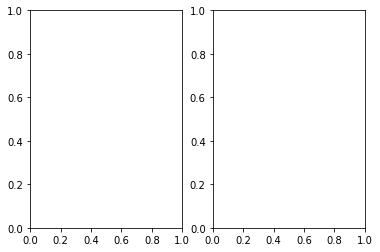

In [82]:
f, ax = plt.subplots(ncols=2)
ax[0].plot(s.cas['snips_sipper']['filt_avg_z'])
for trial in s.cas['snips_sipper']['filt_z']:
    ax[1].plot(trial)


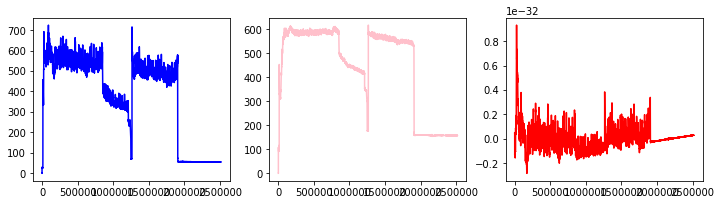

In [8]:
f, ax = plt.subplots(ncols=3, figsize=(12, 3))
ax[0].plot(s.data, color='blue')
ax[1].plot(s.dataUV, color='pink')
ax[2].plot(s.data_filt, color='red')



In [ ]:
# side=s.right
# side['snips_sipper'] = mastersnipper_filt(s, side['sipper'], peak_between_time=[0, 5])
# s.side2subs()

In [ ]:
# ax[0].plot(np.mean(s.cas['snips_sipper']['filt'], axis=0))
# ax[1].plot(np.mean(s.cas['snips_sipper']['filt_z'], axis=0))
# ax[2].plot(np.mean(s.cas['snips_sipper']['filt_z_adjBL'], axis=0))
# ax[3].plot(s.cas['snips_sipper']['filt_avg'])

    
for blue, uv, diff, filt, filt_z in zip(s.cas['snips_sipper']['blue'],
                                        s.cas['snips_sipper']['uv'],
                                        s.cas['snips_sipper']['diff'],
                                        s.cas['snips_sipper']['filt'],
                                        s.cas['snips_sipper']['filt_z']):
    f, ax = plt.subplots(ncols=4, figsize=(12,4))
    ax[0].plot(blue)
    ax[0].plot(uv)
    ax[1].plot(diff)
    ax[2].plot(filt)
    ax[3].plot(filt_z)

In [ ]:
s.cas['snips_sipper']['blue']

In [ ]:
s.cas['snips_licks_forced'].keys()

In [ ]:
s.ttls

In [ ]:
# how do we work out if there are n consecutive values that exceed a certain threshold (z_thresh) in a certain time window (e.g. 0-5 s after event)?
for filt_z in s.cas['snips_sipper']['filt_z']:
#     f, ax = plt.subplots()
#     ax.plot(filt_z)
    thresh = 2.5
    signifarray = [1 if val > thresh else 0 for val in filt_z[100:151]]
    
    
print(signifarray)

In [ ]:
diff = np.diff(signifarray)
diff.index(-1)

In [ ]:
np?